In [7]:
import torch
import os
from torch import nn, autograd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
latent_dim = 100
lr = 0.0001
batch_size = 64
image_size = 28*28
num_epochs = 30
lambda_gp = 10 

OUTPUT_DIR = "./data/wgan"

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Critic (not called discriminator as it does not classify)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Initialize models
generator = Generator().to(device)
critic = Critic().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
c_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

# Gradient penalty
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [6]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        real_images = images.to(device)

        # Train Critic
        for _ in range(5):  # Train critic more often than generator
            c_optimizer.zero_grad()
            fake_images = generator(torch.randn(batch_size, latent_dim, device=device))
            real_validity = critic(real_images)
            fake_validity = critic(fake_images)
            gradient_penalty = compute_gradient_penalty(critic, real_images.data, fake_images.data)
            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
            c_loss.backward()
            c_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        gen_imgs = generator(torch.randn(batch_size, latent_dim, device=device))
        g_loss = -torch.mean(critic(gen_imgs))
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 400 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], C Loss: {c_loss.item()}, G Loss: {g_loss.item()}')

    save_image(fake_images.data[:25], f'./data/wgan/fake_images-{epoch+1}-{i+1}.png', nrow=5, normalize=True)

print("Training complete.")

c:\Users\yumi\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/30], Step [400/937], C Loss: -9.652057647705078, G Loss: -1.6806557178497314
Epoch [1/30], Step [800/937], C Loss: -8.581979751586914, G Loss: -1.238039255142212
Epoch [2/30], Step [400/937], C Loss: -6.869963645935059, G Loss: 3.4662156105041504
Epoch [2/30], Step [800/937], C Loss: -6.536594390869141, G Loss: 3.372313976287842
Epoch [3/30], Step [400/937], C Loss: -6.042079925537109, G Loss: 3.960939884185791
Epoch [3/30], Step [800/937], C Loss: -6.364625930786133, G Loss: 3.721924066543579
Epoch [4/30], Step [400/937], C Loss: -5.767460823059082, G Loss: 3.2272186279296875
Epoch [4/30], Step [800/937], C Loss: -5.661246299743652, G Loss: 2.2898340225219727
Epoch [5/30], Step [400/937], C Loss: -5.140431880950928, G Loss: 2.234757423400879
Epoch [5/30], Step [800/937], C Loss: -5.87972354888916, G Loss: 1.558542251586914
Epoch [6/30], Step [400/937], C Loss: -4.939487457275391, G Loss: 2.1907992362976074
Epoch [6/30], Step [800/937], C Loss: -4.907369613647461, G Loss: 1.46

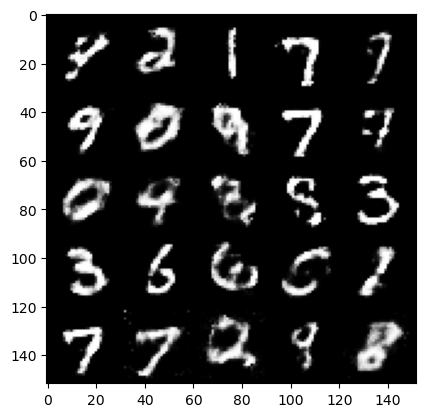

In [10]:
image = Image.open(f'{OUTPUT_DIR}/fake_images-10-937.png')
plt.imshow(image)
plt.show()

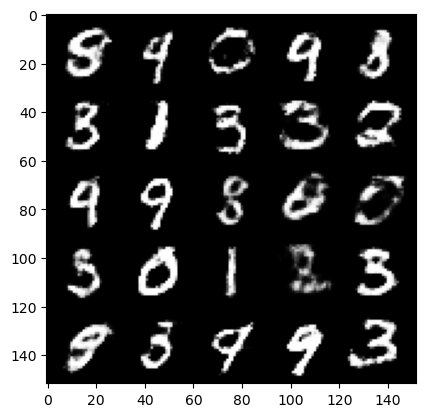

In [11]:
image = Image.open(f'{OUTPUT_DIR}/fake_images-20-937.png')
plt.imshow(image)
plt.show()

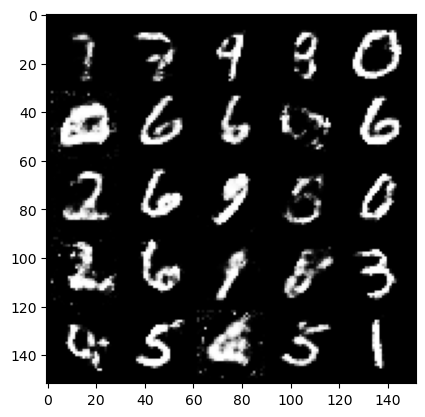

In [12]:
image = Image.open(f'{OUTPUT_DIR}/fake_images-30-937.png')
plt.imshow(image)
plt.show()